# Introduction

This project performs sentiment analysis on WhatsApp chat data using a pre-trained transformer model.
It preprocesses the data, applies sentiment analysis, and visualizes the sentiment distribution and temporal trends.

# Data Cleaning Steps

1. Read the WhatsApp chat data from '_chat.txt'.
2. Extract date, time, sender's phone number or name, and message from each line.
3. Remove emojis from sender's name.
4. Ignore system messages (e.g., "This message was deleted.").
5. Convert the 'Date' column to datetime format.
6. Strip leading and trailing whitespaces and convert 'Phone or Name' and 'Message' to lowercase.
7. Drop rows where 'Phone or Name' is 'ballers' or 'Message' is an empty string.
8. Remove specified patterns from messages (e.g., "This message was edited").


In [ ]:
import re
import pandas as pd
import emoji
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from tqdm import tqdm

In [ ]:
# Importing and Preprocessing Data
with open("_chat.txt", 'r', encoding='utf-8') as text_file:
            # Read the text data
            text_data = text_file.read()

            # Extract date, time, phone number or name, and message from each line
            lines = text_data.splitlines()
            data_rows = []
            for line in lines:
                match = re.match(r'\[(\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{1,2}:\d{1,2})\] (.+?): (.+)', line)
                if match:
                    datetime, phone_or_name, message = match.groups()

                    # Remove emojis
                    phone_or_name= emoji.replace_emoji(phone_or_name, '')

                     # Ignore system messages (e.g., "This message was deleted.")
                    if "This message was deleted." not in message:
                        date, time = datetime.split(', ')
                        data_rows.append([date, time, phone_or_name, message])
             # Create a DataFrame
            df = pd.DataFrame(data_rows, columns=['Date', 'Time', 'Phone or Name', 'Message'])

In [ ]:
df.head()

,Date,Time,Phone or Name,Message
1,2022-11-25,12:14:12,elishama,‎elishama created group “tm/edd👮🏽‍♀️👮🏽‍♂️💵💶💷💴 .2”
3,2022-11-25,12:14:33,elishama,abeg fregz here
4,2022-11-25,12:14:44,elishama,come and explain what ise is
5,2022-11-25,12:14:57,fregz,😂😂😂
6,2022-11-25,12:17:03,tobi,why fregz come dey delete all those messages a...


In [ ]:
# Convert the 'Date' column to a datetime format with the specified date format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Strip leading and trailing whitespaces and convert 'Phone or Name' to lowercase
df['Phone or Name'] = df['Phone or Name'].str.strip().str.lower()

# Strip leading and trailing whitespaces and convert 'Message' to lowercase
df['Message'] = df['Message'].str.strip().str.lower()

# Drop rows where 'Phone or Name' is 'ballers'
df = df.drop(df[df['Phone or Name'] == 'ballers'].index)

# Drop rows where 'Message' is an empty string after stripping whitespaces
df = df.drop(df[df['Message'].str.strip() == ''].index)


In [ ]:
# Define a pattern to identify messages containing "<this message was edited>$"
pattern_to_remove = r"<this message was edited>$"

# Apply a lambda function to each element in the 'Message' column
# to remove the specified pattern from messages
df['Message'] = df['Message'].apply(lambda x: re.sub(pattern_to_remove, '', x))

In [ ]:
patterns_to_drop = [
    r"changed this group's icon",
    r"added (\w+) to the group",
    r"removed (\w+) from the group",
    r"sticker omitted",
    r"image omitted",
    r"elishama created group “tm/edd👮🏽‍♀️👮🏽‍♂️💵💶💷💴 .2”",
]


# Create a condition for rows to drop
condition_to_drop = df['Message'].apply(lambda x: any(re.search(pattern, x, flags=re.IGNORECASE) for pattern in patterns_to_drop))

# Drop rows that match any of the specified patterns
df = df[~condition_to_drop]

# Preprocessing

 Preprocesses messages by replacing mentions and URLs with generic placeholders.


In [ ]:
def preprocess(text):
    # Initialize an empty list to store processed text
    new_text = []

    # Iterate through each word in the input text
    for t in text.split(" "):
        # Replace mentions starting with '@' with '@user'
        t = '@user' if t.startswith('@') and len(t) > 1 else t

        # Replace words starting with 'http' with 'http'
        t = 'http' if t.startswith('http') else t

        # Append the processed word to the list
        new_text.append(t)

    # Join the processed words to form the final preprocessed text
    return " ".join(new_text)


# Sentiment Analysis

1. Defines the sentiment analysis task and specifies the model.
2. Downloads label mapping from a provided URL.
3. Loads the sentiment analysis model.


In [ ]:
# Set the sentiment analysis task and specify the model
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

# Initialize the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Download label mapping from the provided URL
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    # Read and decode the content of the file
    html = f.read().decode('utf-8').split("\n")
    # Use csv.reader to parse the content, assuming tab-delimited format
    csvreader = csv.reader(html, delimiter='\t')
    # Extract labels from the rows with more than one element
    labels = [row[1] for row in csvreader if len(row) > 1]


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

# Sentiment Analysis Function

 Defines a function to get sentiment scores for each message.


In [ ]:
# Apply the preprocess function to clean and format the 'Message' column
df['Message'] = df['Message'].apply(preprocess)

# Load the sentiment analysis model
# Note: Make sure the 'tokenizer' variable is uncommented if needed
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define a function to get sentiment scores for each message
def get_scores(text):
    # Tokenize the preprocessed text and obtain model predictions
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

# Iterate through rows and calculate sentiment scores for each message
for index, row in df.iterrows():
    scores = get_scores(row['Message'])
    # Update the DataFrame with sentiment scores for each label
    for i, label in enumerate(labels):
        df.at[index, label] = np.round(float(scores[i]), 4)


Processing: 100%|██████████| 78900/78900 [43:27<00:00, 30.26it/s]


# Sentiment Analysis Results Visualization

 Visualizes the sentiment distribution and temporal trends.


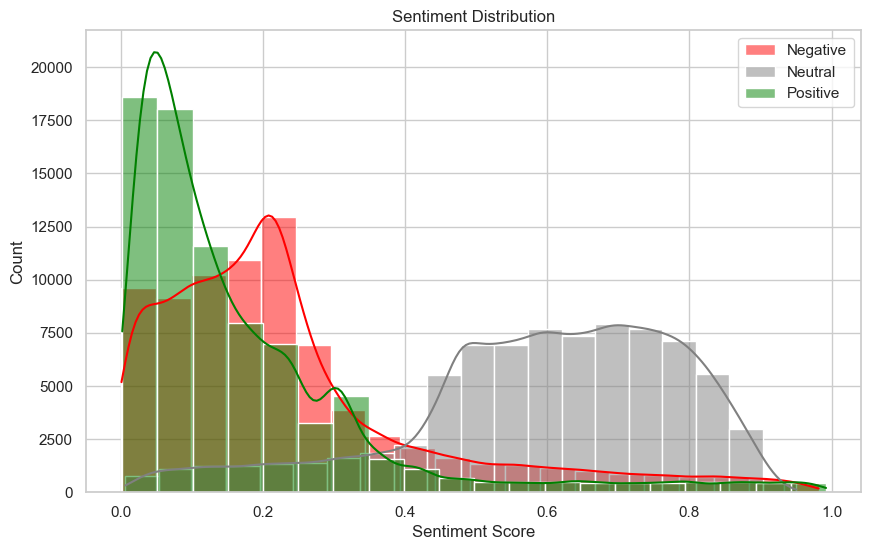

In [ ]:
# Set the style for seaborn
sns.set(style="whitegrid")
e
# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='negative', kde=True, color='red', label='Negative', bins=20)
sns.histplot(data=df, x='neutral', kde=True, color='gray', label='Neutral', bins=20)
sns.histplot(data=df, x='positive', kde=True, color='green', label='Positive', bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.legend()
plt.show()

## Temporal Analysis of Sentiment Scores

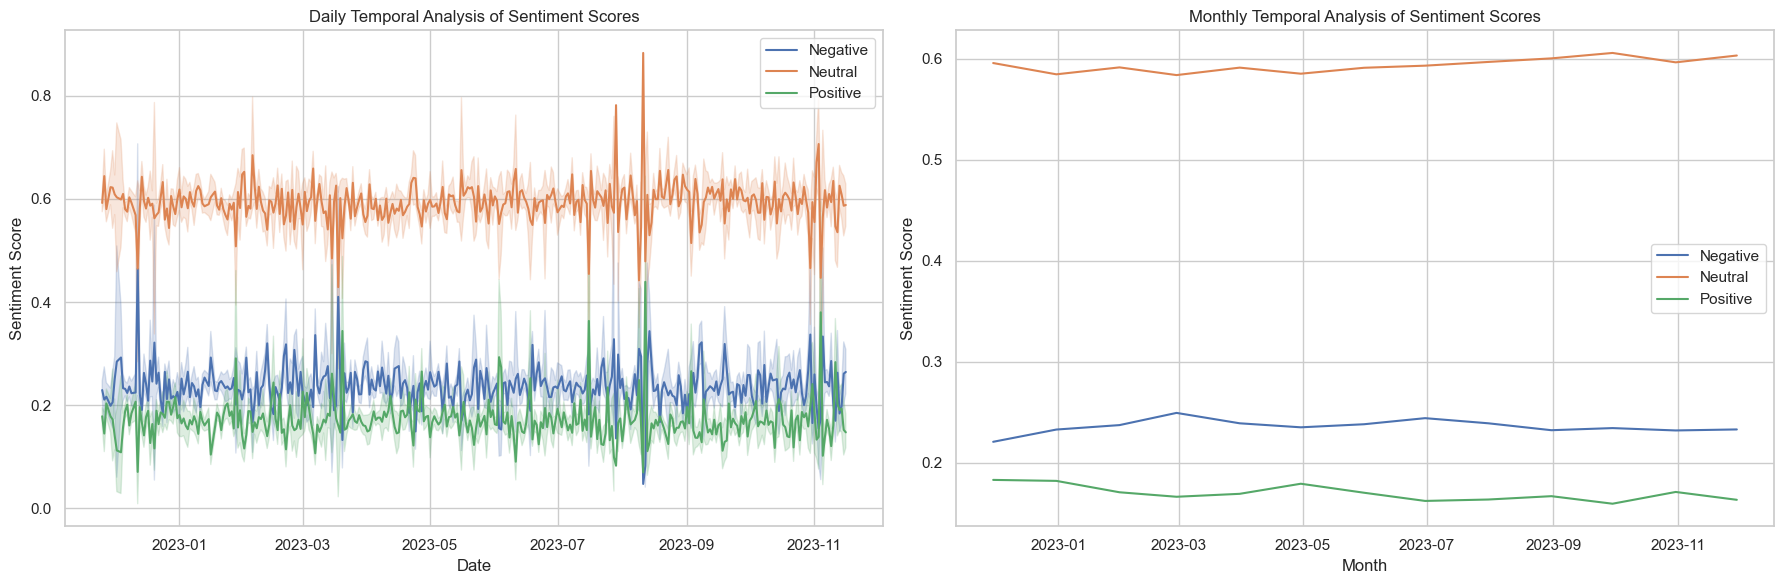

In [ ]:
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot daily sentiment scores
sns.lineplot(data=df, x='Date', y='negative', label='Negative', ax=axes[0])
sns.lineplot(data=df, x='Date', y='neutral', label='Neutral', ax=axes[0])
sns.lineplot(data=df, x='Date', y='positive', label='Positive', ax=axes[0])
axes[0].set_title('Daily Temporal Analysis of Sentiment Scores')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sentiment Score')
axes[0].legend()

# Resample data for monthly sentiment scores
df_monthly = df.resample('M', on='Date').mean()

# Plot monthly sentiment scores
sns.lineplot(data=df_monthly, x='Date', y='negative', label='Negative', ax=axes[1])
sns.lineplot(data=df_monthly, x='Date', y='neutral', label='Neutral', ax=axes[1])
sns.lineplot(data=df_monthly, x='Date', y='positive', label='Positive', ax=axes[1])
axes[1].set_title('Monthly Temporal Analysis of Sentiment Scores')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Sentiment Score')
axes[1].legend()

plt.tight_layout()
plt.show()

# Other Visualizations

1. Number of messages sent each day.
2. Number of messages sent each hour of the day.
3. Number of messages sent by each person.
4. Sender with the highest message count per month.
5. Trend of Messages Sent Over Time


## 1. Number of Messages Sent Each Day

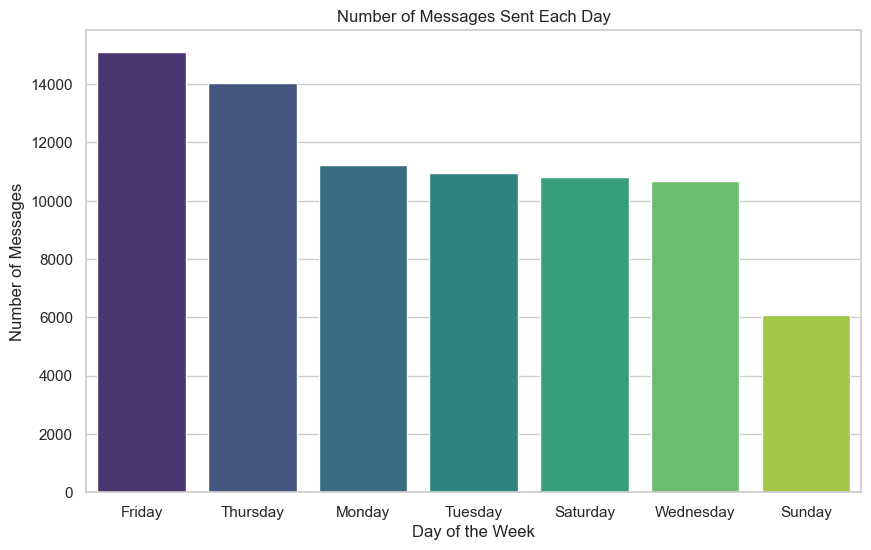

In [ ]:
# Extract day from Date
df['Day'] = df['Date'].dt.day_name()

# Count the number of messages for each day
day_counts = df['Day'].value_counts().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='Day', data=day_counts, palette='viridis')
plt.title('Number of Messages Sent Each Day')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Messages')
plt.show()

### Observation

Friday has the highest number of messages, followed by Thursday, then Monday. This indicates that communication is more active towards the end of the week, possibly due to weekend planning or social activities.

## 2. Number of Messages Sent Each Hour of the Day

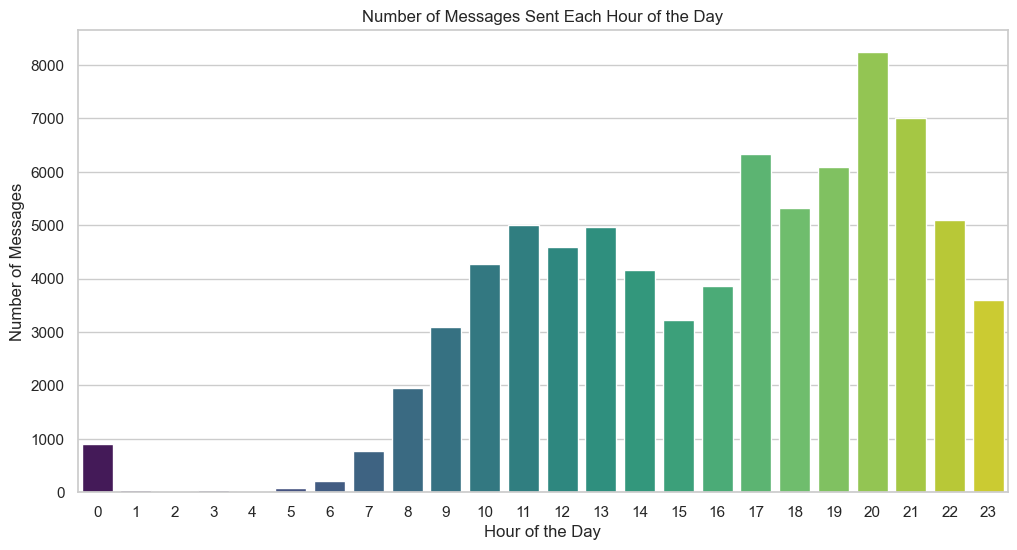

In [ ]:
# Extract hour from Time
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# Count the number of messages for each hour
hour_counts = df['Hour'].value_counts().sort_index().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='Hour', data=hour_counts, palette='viridis')
plt.title('Number of Messages Sent Each Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.show()

### Observation

8 PM or 20:00 has the highest number of messages, followed by 9 PM, then 5 PM. This suggests that the evening hours are peak times for communication among the participants, possibly after work or during leisure time

## 3. Number of Messages Sent by Each Person

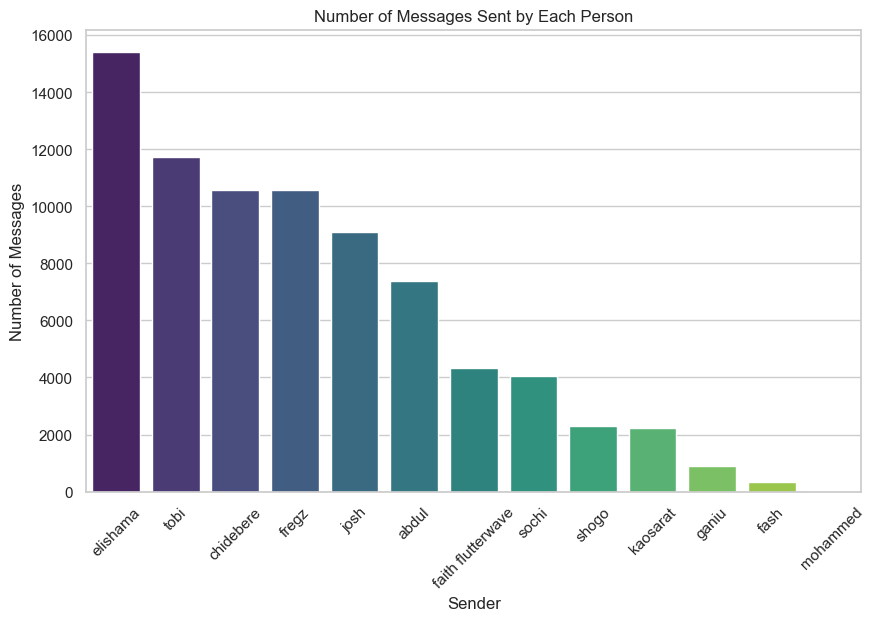

In [ ]:
# Count the number of messages sent by each person
sender_counts = df['Phone or Name'].value_counts().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='Phone or Name', data=sender_counts, palette='viridis')
plt.title('Number of Messages Sent by Each Person')
plt.xlabel('Sender')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.show()

### Observation

Elishama has sent the highest number of messages, followed by Tobi, then Chidebere. This indicates varying levels of activity and participation among the group members, with Elishama being the most prolific communicator.

## 4. Sender with Highest Message Count per Month

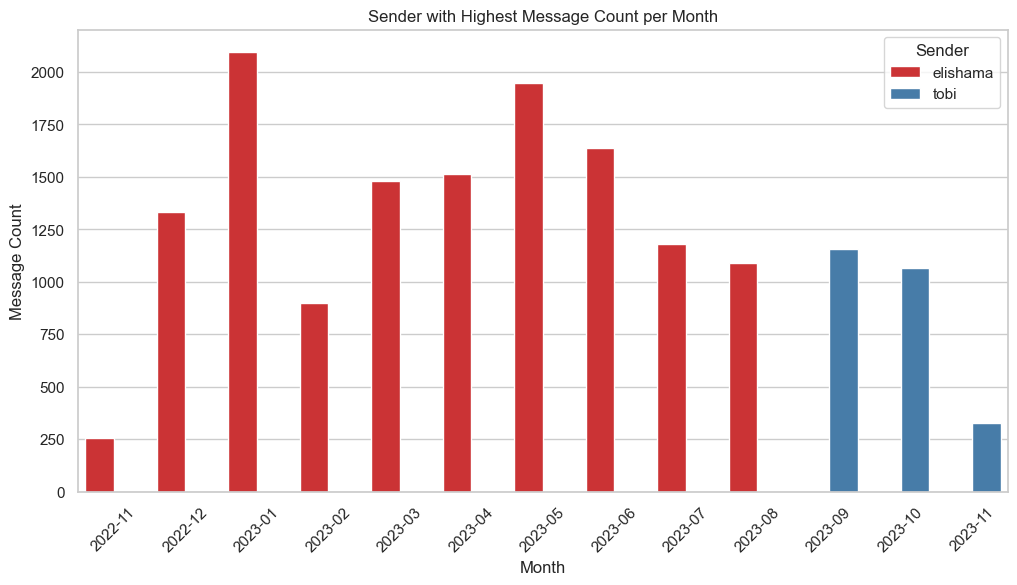

In [ ]:
# Extract month from Date
df['Month'] = df['Date'].dt.to_period('M')

# Group by 'Phone or Name' and 'Month' and count occurrences
sender_counts_per_month = df.groupby(['Phone or Name', 'Month']).size().reset_index(name='Count')

# Find the sender with the highest count per month
sender_with_highest_count_per_month = sender_counts_per_month.loc[sender_counts_per_month.groupby('Month')['Count'].idxmax()]

# Define distinct colors
palette = sns.color_palette("Set1", n_colors=len(df['Phone or Name'].unique()))

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Count', hue='Phone or Name', data=sender_with_highest_count_per_month, palette=palette)
plt.title('Sender with Highest Message Count per Month')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.legend(title='Sender', loc='upper right')
plt.xticks(rotation=45)
plt.show()

### Observation

Elishama has consistently sent the most messages per month from November 2022 until August 2023. However, from September 2023 until November 2023 when the data collection stopped, Tobi becomes the sender with the most messages. This shift in messaging behavior could be due to various factors such as changes in personal circumstances or group dynamics

## Trend of Messages Sent Over Time

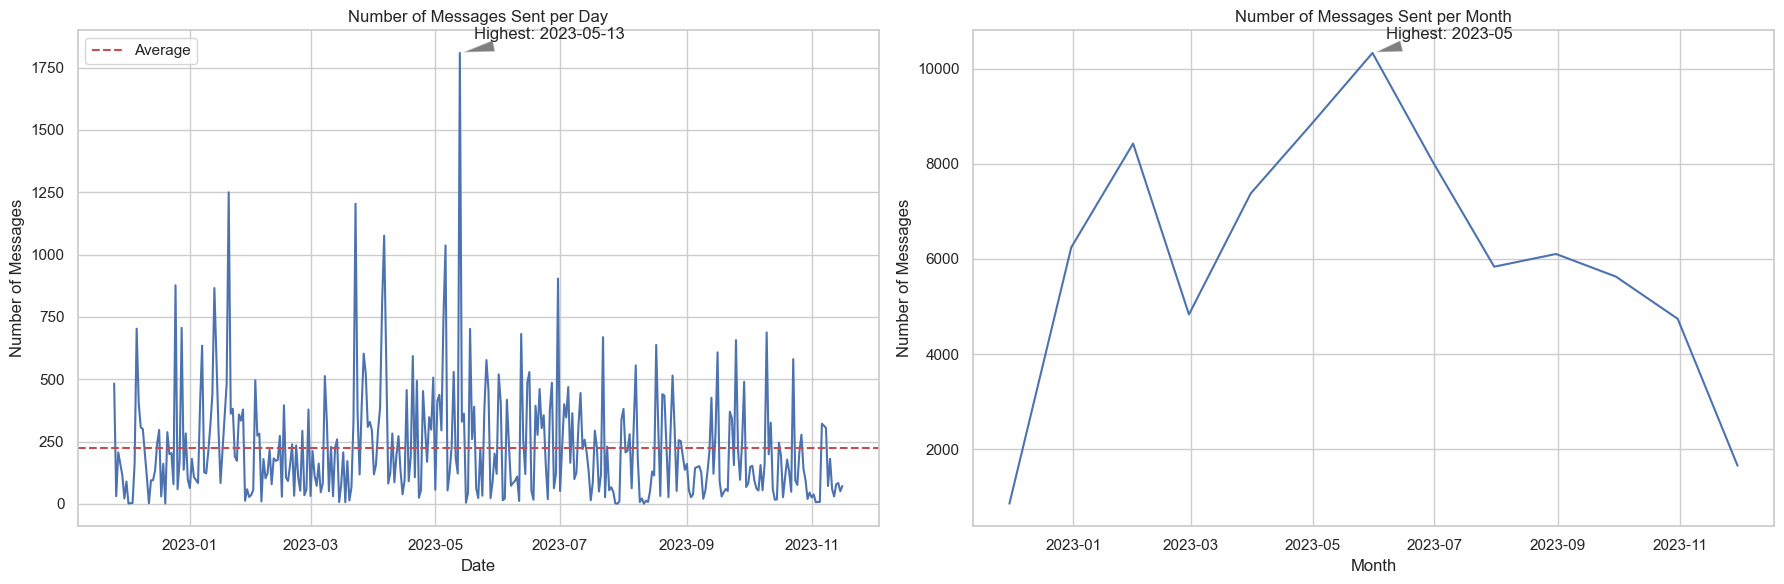

In [ ]:


# Calculate the average number of messages per day
average_messages_per_day = df.groupby('Date')['Message'].count().mean()

# Find the day with the highest number of messages
day_with_highest_messages = df.groupby('Date')['Message'].count().idxmax()
#month_with_highest_messages =df.resample('M', on='Date')['Message'].count().idxmax()

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting messages per day
sns.lineplot(data=df.groupby('Date')['Message'].count().reset_index(), x='Date', y='Message', ax=axes[0])
axes[0].axhline(y=average_messages_per_day, color='r', linestyle='--', label='Average')
axes[0].set_title('Number of Messages Sent per Day')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Messages')
axes[0].legend( loc='upper left')

# Annotate the day with the highest number of messages
axes[0].annotate(
    f'Highest: {day_with_highest_messages.strftime("%Y-%m-%d")}',
    xy=(day_with_highest_messages, df.groupby('Date')['Message'].count().max()),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', lw=1, alpha=0.5)
)

# Plotting messages on a monthly basis
df_monthly_messages = df.resample('M', on='Date')['Message'].count().reset_index()
sns.lineplot(data=df_monthly_messages, x='Date', y='Message', ax=axes[1])
axes[1].set_title('Number of Messages Sent per Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Messages')

# Find the day with the highest number of messages (monthly)
day_with_highest_messages_monthly = df_monthly_messages.loc[df_monthly_messages['Message'].idxmax()]['Date']

# Annotate the day with the highest number of messages for the second plot (monthly)
axes[1].annotate(
    f'Highest: {day_with_highest_messages_monthly.strftime("%Y-%m")}',
    xy=(day_with_highest_messages_monthly, df_monthly_messages['Message'].max()),
    xytext=(10, 10),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', lw=1, alpha=0.5)
)


plt.tight_layout()
plt.show()


### Observation

The data shows constant fluctuations in the number of messages sent both on a daily and monthly basis, indicating varying levels of activity within the chat group over time. The most messages were sent on 2023-05-13, suggesting that something significant or noteworthy may have occurred on that day, leading to increased communication among the participants. Similarly, the highest number of messages was sent in May 2023 on a monthly basis. This could indicate a period of heightened interaction, possibly due to events, discussions, or engagements that took place during that month. Overall, the patterns observed in both daily and monthly message counts reflect the dynamic nature of communication within the chat group, with fluctuations influenced by various factors such as events, discussions, and participant engagement.


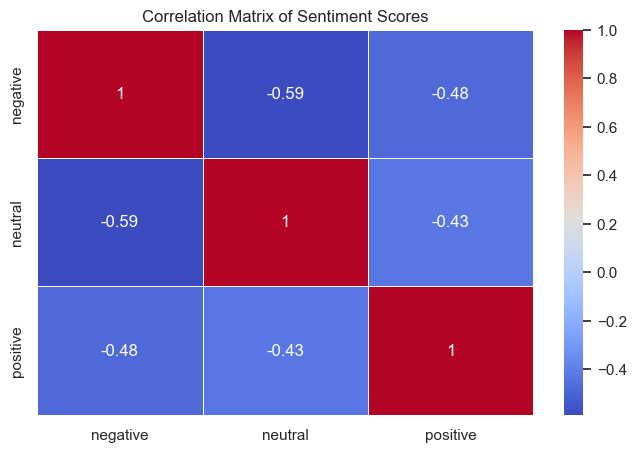

In [ ]:
correlation_matrix = df[['negative', 'neutral', 'positive']].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Sentiment Scores')
plt.show()

In [ ]:
# Find the index of the most positive, neutral, and negative messages
index_most_positive = df['positive'].idxmax()
index_most_neutral = df['neutral'].idxmax()
index_most_negative = df['negative'].idxmax()

# Retrieve the most positive, neutral, and negative messages
most_positive_message = df.loc[index_most_positive, 'Message']
most_neutral_message = df.loc[index_most_neutral, 'Message']
most_negative_message = df.loc[index_most_negative, 'Message']

# Print the results
print("Most Positive Message:", most_positive_message)
print("Most Neutral Message:", most_neutral_message)
print("Most Negative Message:", most_negative_message)

Most Positive Message: sochyyyy happiest birthday to you!!!❤️
Most Neutral Message: would you prefer to be on monday with anthony, kehinde, mohammed and ganiu or tuesday with your guys?
Most Negative Message: you guys are not nice at all


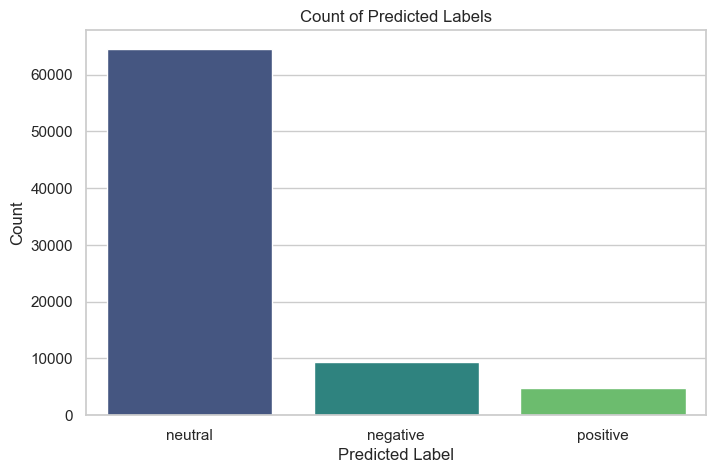

In [ ]:

# Find the label with the highest sentiment score for each message
df['Predicted_Label'] = df[['positive', 'neutral', 'negative']].idxmax(axis=1)

# Count occurrences of each predicted label
label_counts = df['Predicted_Label'].value_counts().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='index', y='Predicted_Label', data=label_counts, palette='viridis')
plt.title('Count of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()


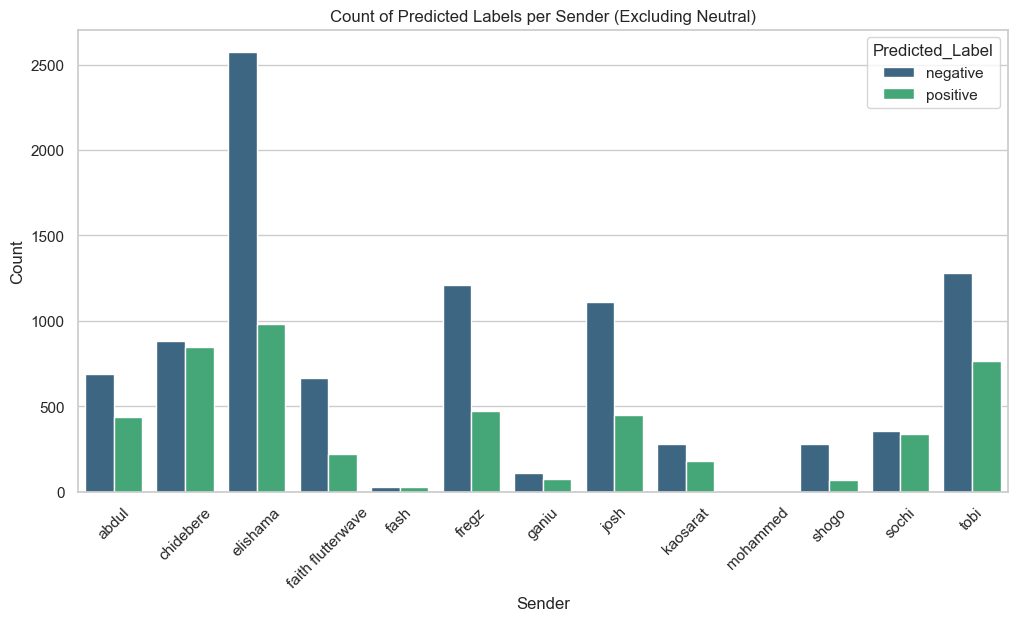

In [ ]:
# Exclude 'neutral' category
df_without_neutral = df[df['Predicted_Label'] != 'neutral']

# Group by 'Phone or Name' and 'Predicted_Label' and count occurrences
label_counts_per_sender = df_without_neutral.groupby(['Phone or Name', 'Predicted_Label']).size().reset_index(name='Count')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Phone or Name', y='Count', hue='Predicted_Label', data=label_counts_per_sender, palette='viridis')
plt.title('Count of Predicted Labels per Sender (Excluding Neutral)')
plt.xlabel('Sender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.to_csv("whatsapp_project.csv", index= False )